In [2600]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.externals import joblib

data = pd.read_json('uebungs2datei.json')
data.tail()

,calEvents,datumBeginn,datumEnde,desc,gruppenName,name,newEvents,ort,score,speichern,uhrzeitBeginn,uhrzeitEnde,url
937,[],,,<p>Inhalt des 20. Info-Treffs</p> <p>C++ im Em...,C++ User Group Karlsruhe,C++ im Embedded-Medizinger�t � Lohnt der Einsa...,[],"Am Fasanengarten 5, Karlsruhe",16,True,,,https://www.meetup.com/C-User-Group-Karlsruhe/...
938,[],2018-09-01,2018-09-01,<p>OFFIZIELLER BOOTCAMP TRAILER?:<br/><a href=...,Bootcamp (Mannheim),Bootcamp,[],"Ecke Otto-Beck-Stra�e/Kolpingstra�e, Treffpunk...",19,True,11:00,12:00,https://www.meetup.com/Bootcamp-Mannheim/event...
939,[],2018-09-02,2018-09-02,<p>OFFIZIELLER BOOTCAMP TRAILER?:<br/><a href=...,Bootcamp Ludwigshafen,Bootcamp,[],"Saarlandstra�e 70, 67061 Ludwigshafen am Rhein...",19,True,11:00,12:00,https://www.meetup.com/Bootcamp-Ludwigshafen/e...
940,[],,,<p>Are you longing to hear and talk about that...,karlsruhe.ai,[Casual] Community Conversation about Machine ...,[],"Haid-und-Neu Str. 18, Karlsruhe, Karlsruhe",20,True,,,https://www.meetup.com/karlsruhe-ai/events/253...
941,[],,,"<p>In this event, we discuss scientific papers...",karlsruhe.ai,[PaperDiscussion] Computational Protein Design...,[],"Am Fasanengarten 5, Karlsruhe",23,True,,,https://www.meetup.com/karlsruhe-ai/events/253...


In [2551]:
data['speichern'].value_counts()

False    819
True     123
Name: speichern, dtype: int64

# HTML-Tags in Beschreibung entfernen

In [2552]:
imp_data = data[['speichern','desc','gruppenName','name','ort']]

In [2553]:
imp_data_plain = imp_data.copy()
imp_data_plain['desc']=imp_data['desc'].apply(lambda x : x.replace('"',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('<p>',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('</p>',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('<b>',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('</b>',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('\\n',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('\\>',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('/>',''))

In [2554]:
imp_data_plain.head()

,speichern,desc,gruppenName,name,ort
0,False,[Technisches Verst�ndnis und Kenntnisse in der...,NaN,,
1,False,Kultur im Cyberspace und jugendliche Lebenswel...,NaN,,
2,False,[Kommunikation mit Computern ist wundervoll ei...,NaN,,
3,False,Talklet (Vortrags- und Diskussionsabend) am Do...,NaN,,
4,False,"[NOSQL, Big Data und Graphen sind zur Zeit in ...",NaN,,


# Datenset splitten

In [2555]:
X_all = imp_data_plain.drop('speichern', axis=1)
Y_all = imp_data_plain["speichern"]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in sss.split(X_all, Y_all):
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    Y_train, Y_test = Y_all.iloc[train_index], Y_all.iloc[test_index]

# Beschreibungen vectorisieren und Vokabular anlegen

In [2556]:
def isSubstantiv(x):
    x3 = ""
    xtemp = x.split(' ')
    for i in xtemp:
        if not i.islower() or i.isdigit() or i.isupper():
                x3 = x3 + " " + i
    return x3

X_train_voc =  X_train['desc'].apply(lambda x : isSubstantiv(x))

cv = TfidfVectorizer(token_pattern = '(?ui)\\b\\w*[a-z]\\w*[a-z]\\b',min_df=0.02, max_df = 0.7)

cv.fit(X_train_voc)
X_train_cv = cv.transform(X_train['desc'])

In [2557]:
len(X_train_voc)

753

In [2558]:
X_train_voc

80                                                      
885     [F�r Veranstaltung Beschreibung., KIT Karlsru...
749     Aein Gl�sel Woi Musi Spa� Gass... Woifescht! ...
825     Talklet (Vortrags- Diskussionsabend) Donnerst...
429     Dienstag, 22. November 2011, 18.30 Uhr\n\n13....
115     Treffen\n\nhttp://ka.stadtwiki.net/Stadtwiki:...
473     Talklet (Vortrags- Diskussionsabend) Dienstag...
401     Einladung ObjektForum Stuttgart Montag, 3. Ma...
12      Veranstaltung Vortr�gen JUG Berlin-Brandenbur...
532     Talklet (Vortrags- Diskussionsabend) Donnerst...
576     [JUnit Bereich TDD Java Entwickler Werkzeug. ...
447     Einladung ObjektForum Stuttgart Montag, 10. J...
274     Neben Datenbank Datentypen SQL Server 2008 Da...
581     [Nein, Mocks! M�ssen Sie Application Server B...
386     Dienstag, 16. Juni 2009, 18.30 Uhr: \nEinladu...
479     Workshop Java Entscheider 8. Juli Kultur- & K...
519     Einladung ObjektForum Stuttgart Montag, 20. N...
430     Liebe JUGS-Mitglieder,\

In [2559]:
len(cv.get_feature_names())

267

In [2560]:
cv.get_feature_names()

['abend',
 'aber',
 'abstract',
 'ag',
 'agile',
 'alle',
 'als',
 'am',
 'an',
 'andrena',
 'anfahrt',
 'anforderungen',
 'anmeldung',
 'anschluss',
 'anwendung',
 'anwendungen',
 'apache',
 'api',
 'application',
 'april',
 'architekt',
 'architektur',
 'atmosph',
 'autor',
 'basis',
 'bei',
 'beispiel',
 'bereich',
 'berlin',
 'bio',
 'bitte',
 'blick',
 'br',
 'business',
 'che',
 'class',
 'cloud',
 'club',
 'co',
 'code',
 'com',
 'community',
 'consultant',
 'dabei',
 'das',
 'data',
 'daten',
 'de',
 'degerloch',
 'der',
 'design',
 'details',
 'deutschland',
 'die',
 'dienstag',
 'diese',
 'dieser',
 'diskussion',
 'diskussionsabend',
 'donnerstag',
 'dr',
 'du',
 'eclipse',
 'ee',
 'ein',
 'eine',
 'einf',
 'einladung',
 'einsatz',
 'eintritt',
 'end',
 'ende',
 'enterprise',
 'entwickler',
 'entwicklung',
 'er',
 'erfahrung',
 'erfahrungen',
 'es',
 'event',
 'events',
 'fasanengarten',
 'features',
 'forum',
 'frage',
 'fragen',
 'framework',
 'frameworks',
 'ge',
 'geb',
 

In [2561]:
Y_train = Y_train.astype('int')

In [2562]:
Y_test = Y_test.astype('int')

In [2563]:
X_test_cv = cv.transform(X_test['desc'])

In [2564]:
def myEvaluation(y_pred):
    print(classification_report(Y_test, y_pred, digits=4))
    sns.heatmap(confusion_matrix(Y_test, y_pred), square=True, annot=True)
    plt.show()

# DecisionTree

             precision    recall  f1-score   support

          0     0.9756    0.9756    0.9756       164
          1     0.8400    0.8400    0.8400        25

avg / total     0.9577    0.9577    0.9577       189



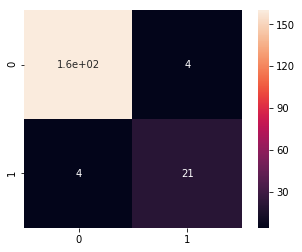

In [2565]:
clf_tree = tree.DecisionTreeClassifier(max_depth=70)
clf_tree.fit(X_train_cv, Y_train)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# DecisionTree + ROS

             precision    recall  f1-score   support

          0     0.9758    0.9817    0.9787       164
          1     0.8750    0.8400    0.8571        25

avg / total     0.9624    0.9630    0.9626       189



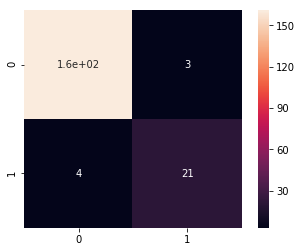

In [2566]:
ros = RandomOverSampler()
X_ros_res, y_ros_res = ros.fit_sample(X_train_cv, Y_train)
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_ros_res, y_ros_res)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# DecisionTree + SMOTE

             precision    recall  f1-score   support

          0     0.9814    0.9634    0.9723       164
          1     0.7857    0.8800    0.8302        25

avg / total     0.9555    0.9524    0.9535       189



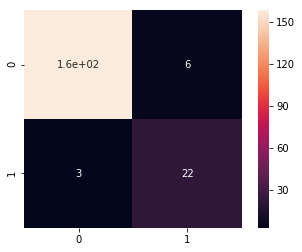

In [2567]:
s = SMOTE()
X_s_res, y_s_res = s.fit_sample(X_train_cv, Y_train)
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_s_res, y_s_res)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# Decisiontree + ADASYN

             precision    recall  f1-score   support

          0     0.9756    0.9756    0.9756       164
          1     0.8400    0.8400    0.8400        25

avg / total     0.9577    0.9577    0.9577       189



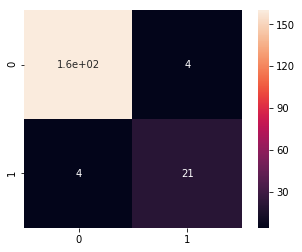

In [2568]:
ada = ADASYN()
X_ada_res, y_ada_res = ada.fit_sample(X_train_cv, Y_train)
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_ada_res, y_ada_res)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# DecisionTree + RandomUnderSampler

             precision    recall  f1-score   support

          0     0.9801    0.9024    0.9397       164
          1     0.5789    0.8800    0.6984        25

avg / total     0.9271    0.8995    0.9078       189



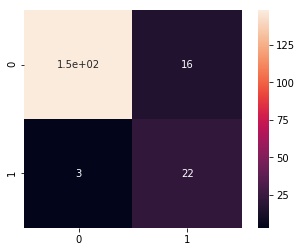

In [2569]:
rus = RandomUnderSampler()
X_rus_res, y_rus_res = rus.fit_sample(X_train_cv, Y_train)
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_rus_res, y_rus_res)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# RandomForestTree

             precision    recall  f1-score   support

          0     0.9704    1.0000    0.9850       164
          1     1.0000    0.8000    0.8889        25

avg / total     0.9743    0.9735    0.9723       189



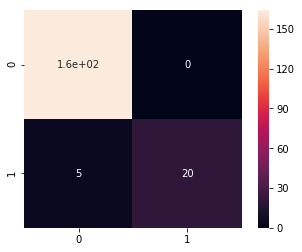

In [2570]:
clf_rdm_tree = RandomForestClassifier(n_estimators=75, max_depth=50)
clf_rdm_tree.fit(X_train_cv, Y_train)
y_pred_rdmForest = clf_rdm_tree.predict(X_test_cv)
myEvaluation(y_pred_rdmForest)

# AdaBoostTree

             precision    recall  f1-score   support

          0     0.9758    0.9817    0.9787       164
          1     0.8750    0.8400    0.8571        25

avg / total     0.9624    0.9630    0.9626       189



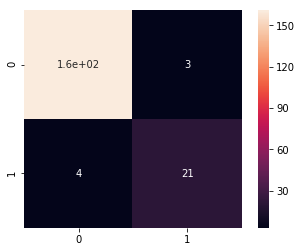

In [2571]:
clf_adaBoost_tree = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=50),
                         algorithm="SAMME",
                         n_estimators= 100)

clf_adaBoost_tree.fit(X_train_cv, Y_train)
y_pred_adaBoost = clf_adaBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_adaBoost)

             precision    recall  f1-score   support

          0     0.9873    0.9512    0.9689       164
          1     0.7419    0.9200    0.8214        25

avg / total     0.9549    0.9471    0.9494       189



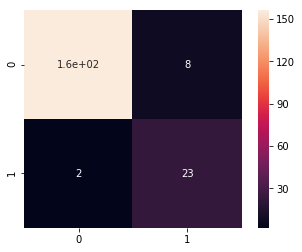

In [2572]:
rus = SMOTE()
X_rus_res, y_rus_res = rus.fit_sample(X_train_cv, Y_train)
clf_adaBoost_tree = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=50),
                         algorithm="SAMME",
                         n_estimators= 100)

clf_adaBoost_tree.fit(X_rus_res, y_rus_res)
y_pred_adaBoost = clf_adaBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_adaBoost)

# GradientBoostingTree

             precision    recall  f1-score   support

          0     0.9760    0.9939    0.9849       164
          1     0.9545    0.8400    0.8936        25

avg / total     0.9732    0.9735    0.9728       189



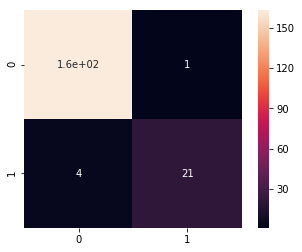

In [2573]:
clf_gradBoost_tree1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=50)
clf_gradBoost_tree1.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree1.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9759    0.9878    0.9818       164
          1     0.9130    0.8400    0.8750        25

avg / total     0.9676    0.9683    0.9677       189



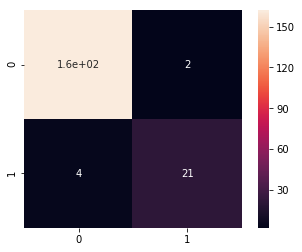

In [2574]:
clf_gradBoost_tree2 = GradientBoostingClassifier(n_estimators=75, learning_rate=0.1, max_depth=50)
clf_gradBoost_tree2.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree2.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9760    0.9939    0.9849       164
          1     0.9545    0.8400    0.8936        25

avg / total     0.9732    0.9735    0.9728       189



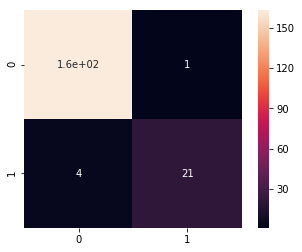

In [2575]:
clf_gradBoost_tree3 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=50)
clf_gradBoost_tree3.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree3.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9759    0.9878    0.9818       164
          1     0.9130    0.8400    0.8750        25

avg / total     0.9676    0.9683    0.9677       189



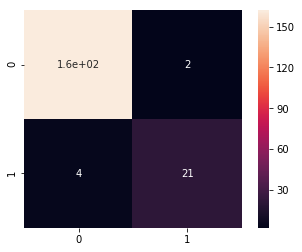

In [2576]:
clf_gradBoost_tree4 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=75)
clf_gradBoost_tree4.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree4.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9758    0.9817    0.9787       164
          1     0.8750    0.8400    0.8571        25

avg / total     0.9624    0.9630    0.9626       189



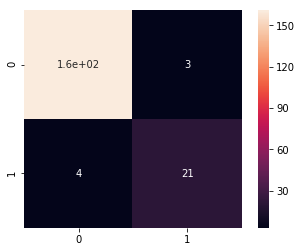

In [2577]:
clf_gradBoost_tree5 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=100)
clf_gradBoost_tree5.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree5.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9760    0.9939    0.9849       164
          1     0.9545    0.8400    0.8936        25

avg / total     0.9732    0.9735    0.9728       189



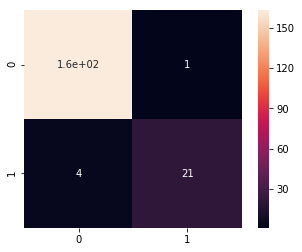

In [2578]:
clf_gradBoost_tree6 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=40)
clf_gradBoost_tree6.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree6.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9758    0.9817    0.9787       164
          1     0.8750    0.8400    0.8571        25

avg / total     0.9624    0.9630    0.9626       189



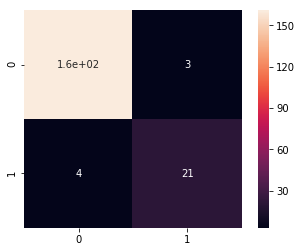

In [2579]:
clf_gradBoost_tree7 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=30)
clf_gradBoost_tree7.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree7.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9760    0.9939    0.9849       164
          1     0.9545    0.8400    0.8936        25

avg / total     0.9732    0.9735    0.9728       189



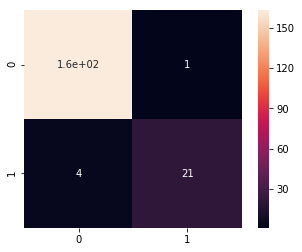

In [2580]:
clf_gradBoost_tree8 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=20)
clf_gradBoost_tree8.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree8.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

# GradientBoostingTree + ROS

             precision    recall  f1-score   support

          0     0.9817    0.9817    0.9817       164
          1     0.8800    0.8800    0.8800        25

avg / total     0.9683    0.9683    0.9683       189



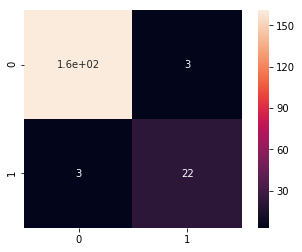

In [2581]:
ros = RandomOverSampler()
X_ros_res, y_ros_res = ros.fit_sample(X_train_cv, Y_train)
clf_gradBoost_tree9 = GradientBoostingClassifier(n_estimators=75, learning_rate=0.1, max_depth=50)
clf_gradBoost_tree9.fit(X_rus_res, y_rus_res)
y_pred_gradBoost = clf_gradBoost_tree9.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

# GradientBoostingTree + RUS

             precision    recall  f1-score   support

          0     0.9934    0.9146    0.9524       164
          1     0.6316    0.9600    0.7619        25

avg / total     0.9455    0.9206    0.9272       189



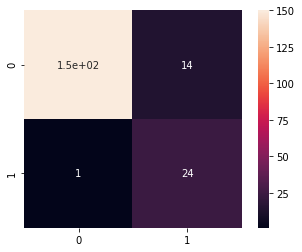

In [2582]:
rus = RandomUnderSampler()
X_rus_res, y_rus_res = rus.fit_sample(X_train_cv, Y_train)
clf_gradBoost_tree10 = GradientBoostingClassifier(n_estimators=75, learning_rate=0.1, max_depth=30)
clf_gradBoost_tree10.fit(X_rus_res, y_rus_res)
y_pred_gradBoost = clf_gradBoost_tree10.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

In [2596]:
joblib.dump(clf_gradBoost_tree, 'clf_gradBoost_tree.pkl') 

['clf_gradBoost_tree.pkl']